In [1]:
import dataset
import model

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as T

torch.cuda.is_available()

True

In [2]:
DEVICE = torch.device('cuda')

In [3]:
transform = T.Compose([
    T.ToTensor(),
#     T.RandAugment(),
    T.RandomResizedCrop(256, scale=(0.5, 1.0), ratio=(1,1)),
    
#     T.RandomCrop(256),
])

def pil_loader(path: str) -> Image.Image:
    with open(path, "rb") as f:
        img = Image.open(f)
        return img.convert("RGB")

train_data = torchvision.datasets.DatasetFolder(
    '/data/cse455/train',
    extensions=('.png',),
    transform=transform,
    loader=pil_loader
)
train_loader = DataLoader(train_data, batch_size=8, shuffle=True, num_workers=8)

In [4]:
x, _ = next(iter(train_loader))
x.shape

torch.Size([8, 3, 256, 256])

In [5]:
encoder = model.Encoder(requires_grad=True, output_channels=3).to(DEVICE)
decoder = model.Decoder(requires_grad=True, input_channels=3).to(DEVICE)

In [ ]:
epochs = 3

optimizer = torch.optim.AdamW([*encoder.parameters(), *decoder.parameters()], lr=1e-4, )
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_loader)*3)
criterion = nn.MSELoss()

for epoch in (bar_e := tqdm(range(epochs))):
    for X, _ in (bar_b := tqdm(train_loader)):
        X = X.to(DEVICE)
        
        optimizer.zero_grad()
        
        z = encoder(X)
        X_ = decoder(z)
        
        loss = criterion(X_, X)
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        
        bar_b.set_postfix(loss=loss.item())

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3183 [00:00<?, ?it/s]

  0%|          | 0/3183 [00:00<?, ?it/s]

  0%|          | 0/3183 [00:00<?, ?it/s]

In [ ]:
torch.save(encoder, 'encoder3.pt')
torch.save(decoder, 'decoder3.pt')

In [339]:
encoder_ = torch.load('encoder.pt').to('cpu')
decoder_ = torch.load('decoder.pt').to('cpu')

encoder = model.Encoder(requires_grad=False, output_channels=10).to('cpu')
decoder = model.Decoder(requires_grad=False, input_channels=10).to('cpu')

encoder.load_state_dict(encoder_.state_dict())
decoder.load_state_dict(decoder_.state_dict())

<All keys matched successfully>

In [70]:
# encoder = torch.load('encoder3.pt').to('cpu')
# decoder = torch.load('decoder3.pt').to('cpu')
# encoder = torch.load('encoder.pt').to('cpu')
# decoder = torch.load('decoder.pt').to('cpu')

In [340]:
encoder.requires_grad_(False)
sum(p.numel() for p in encoder.parameters() if p.requires_grad)

0

In [341]:
rrc = T.RandomResizedCrop(256, scale=(0.5, 1.0), ratio=(1,1))

def dual_crop(img, depth):
    img = T.functional.to_tensor(img)
    crop = rrc.get_params(img, rrc.scale, rrc.ratio)
    img = T.functional.resized_crop(img, *crop, rrc.size, rrc.interpolation, antialias=rrc.antialias)
    depth = T.functional.resized_crop(depth, *crop, rrc.size, rrc.interpolation, antialias=rrc.antialias)
#     depth = T.functional.resize(depth, 32)
    return img, depth

train_data = dataset.DepthDataset('/data/cse455/train', dual_transform=dual_crop)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=8)

In [83]:
x, y = next(iter(train_loader))
x.shape, y.shape, y.min(), y.float().mean(), y.max()

(torch.Size([32, 3, 256, 256]),
 torch.Size([32, 1, 256, 256]),
 tensor(0.),
 tensor(8.8530),
 tensor(260.0448))

In [84]:
x_ = decoder(encoder(x))

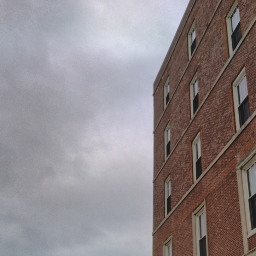

In [88]:
i = 5
T.functional.to_pil_image(x[i])

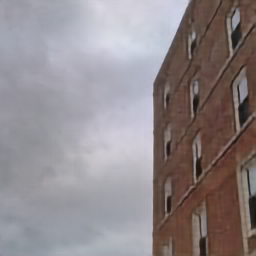

In [89]:
T.functional.to_pil_image(x_[i].clamp(0,1))

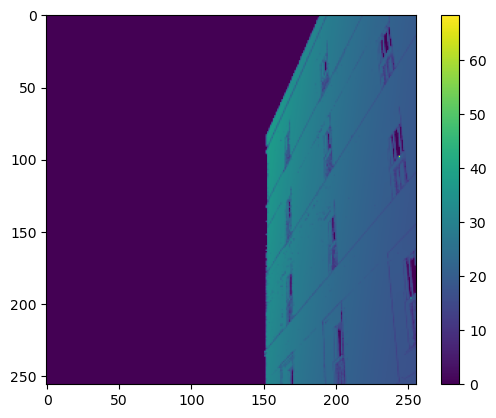

In [90]:
plt.imshow(y[i,0])
plt.colorbar()
plt.show()

In [117]:
convnext = torchvision.models.convnext_base(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /home/i2/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth


  0%|          | 0.00/338M [00:00<?, ?B/s]

In [126]:
convnext.requires_grad_(False)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

In [124]:
x.shape

torch.Size([32, 3, 256, 256])

In [125]:
x

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

In [345]:
def convert_depth(raw):
    depth = T.functional.resize(raw, 32)
    for i in range(len(depth)):
        depth[i] -= depth[i].min()
        depth[i] /= (depth[i].max() + 0.001)
    
#     return torch.where(depth==0, 100, depth)
#     return (depth+1).log()
    return depth

In [346]:
# encoder = convnext.features.to(DEVICE)
encoder = encoder.to(DEVICE)
# linear_probe = nn.Conv2d(1024, 1, 1).to(DEVICE)
linear_probe = nn.Conv2d(encoder.output_channels, 1, 1).to(DEVICE)

In [347]:
epochs = 1

log = []

optimizer = torch.optim.Adam(linear_probe.parameters(), lr=1e-4, )
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_loader))
criterion = nn.MSELoss()
# criterion = nn.L1Loss()

for epoch in (bar_e := tqdm(range(epochs))):
    for X, raw in (bar_b := tqdm(train_loader)):
        X = X.to(DEVICE)
        raw = raw.to(DEVICE)
        
        y = convert_depth(raw)
        
        optimizer.zero_grad()
        
        pred = linear_probe(encoder(X))
        pred = torch.where(y==0, y, pred)
        
        loss = criterion(pred, y)
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        
        bar_b.set_postfix(loss=loss.item())
        log.append(loss.item())

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/796 [00:00<?, ?it/s]

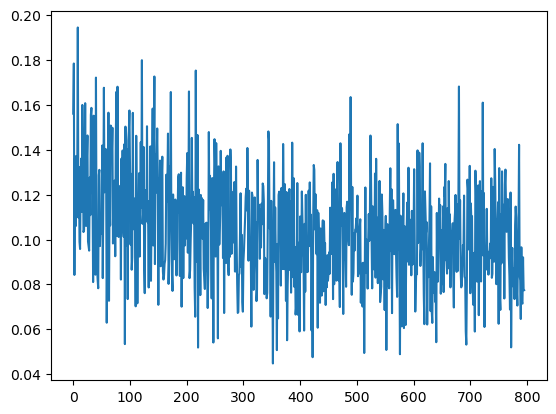

In [348]:
# autoencoder
plt.plot(log)

In [349]:
encoder = encoder.to('cpu')
linear_probe = linear_probe.to('cpu')

In [350]:
x, y = next(iter(train_loader))
d = convert_depth(y)
d_ = linear_probe(encoder(x)).detach()

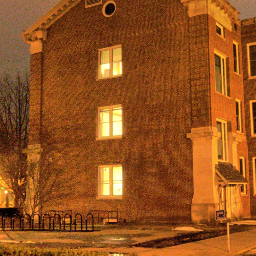

In [389]:
i = 14
T.functional.to_pil_image(x[i])

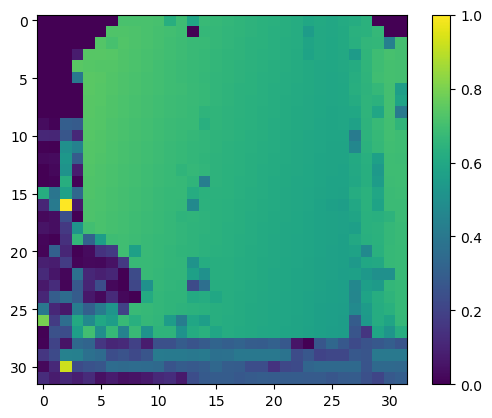

In [390]:
plt.imshow(d[i,0], vmin=0, vmax=1)
plt.colorbar()
plt.show()

In [1]:
a = d_[i,0].detach()
# a -= a.min()
# a /= a.max() + 0.0001

# plt.imshow(d_[i,0].detach(), vmin=0, vmax=1)
plt.imshow(a, vmin=0, vmax=1)
plt.colorbar()
plt.show()

NameError: name 'd_' is not defined

In [6]:
encoder = encoder.to('cpu')
decoder = decoder.to('cpu')